<h1 style="text-align:center;">Generate all plots 🧀</h1>

In [8]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## A smoothing function

We smoothed some of the curves for legibility. To quickly check where this happened, do a ctrl+F on "moving_average".
To disable this smoothing, uncomment the final line in the following block and re-run the notebook.

In [2]:
def moving_average(x, w):
    # First convolve with vector of ones of width w
    convolution = np.convolve(x, np.ones(w), 'same') / w
    
    # Handle edge effects gracefully
    for idx in range((w-1)//2):
        convolution[idx] *= w / ((w-1)//2 + idx+1)
        convolution[-idx-1] *= w / ((w-1)//2 + idx+1)
    return convolution

## To disable smoothing in all plots, uncomment the following line.
# moving_average = (lambda x,w : x)

## Curvature slices
This block generates Figure 2 in the paper.

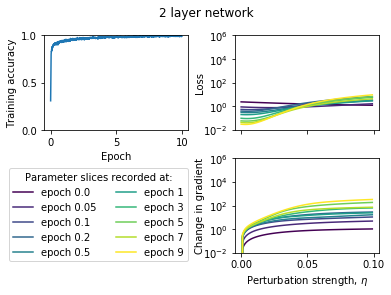

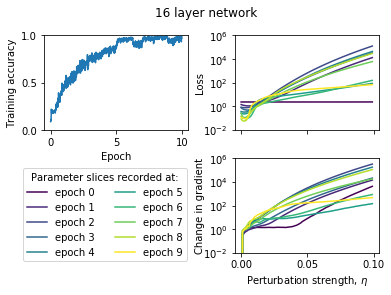

In [3]:
for depth in [1,15]:
    num_steps=100
    epochs=10
    grad_changes = np.load(f'logs/mnist-curvature/depth{depth}_grad_changes.npy',allow_pickle=True)[0:10]
    loss_slices = np.load(f'logs/mnist-curvature/depth{depth}_loss_slices.npy',allow_pickle=True)[0:10]
    training_acc = np.load(f'logs/mnist-curvature/depth{depth}_training_acc.npy',allow_pickle=True)[0:240*10]
    training_acc = moving_average(training_acc, w=5) # smooth the training acc since it's recorded on minibatches
    perturbation_list = np.array(range(num_steps))*0.001

    def ax_plot(ax, curves):
        colors = plt.cm.viridis(np.linspace(0,1,epochs))
        for epoch in range(epochs):
            curve = curves[epoch]
            ax.plot(perturbation_list, curve, color=colors[epoch])

    fig,a =  plt.subplots(2,2)
    fig.suptitle(f'{depth+1} layer network') # We add one to the depth because the count does not include the output layer.
    a[0][0].plot(np.array(range(len(training_acc)))/240,training_acc)
    a[0][0].set_xlabel('Epoch')
    a[0][0].set_ylabel('Training accuracy')
    a[0][0].set_ylim(0.0,1)
    a[0][0].set_yticks([0.0,0.5,1])

    a[1][0].axis('off')

    ax_plot(a[0][1], loss_slices)
    a[0][1].set_ylabel('Loss')
    a[0][1].set_xticklabels([])
    a[0][1].set_yscale("log")
    a[0][1].yaxis.labelpad = -2.0
    a[0][1].set_yticks([0.01,1,100,10000,1000000])

    ax_plot(a[1][1], grad_changes)
    a[1][1].set_xlabel(r'Perturbation strength, $\eta$')
    a[1][1].set_ylabel('Change in gradient')
    a[1][1].set_yscale("log")
    a[1][1].set_yticks([0.01,1,100,10000,1000000])
    a[1][1].yaxis.labelpad = -2.0
    if depth == 15:
        a[1][1].legend(labels = ["epoch "+str(x) for x in range(epochs)], title="Parameter slices recorded at:", loc = 'center left', bbox_to_anchor=(-1.5, 0.4), ncol=2)
    elif depth == 1:
        epoch_list = [0.0, 0.05, 0.1, 0.2, 0.5, 1, 3, 5, 7, 9]
        a[1][1].legend(labels = ["epoch "+str(x) for x in epoch_list], title="Parameter slices recorded at:", loc = 'center left', bbox_to_anchor=(-1.6, 0.4), ncol=2)

    plt.subplots_adjust(wspace = 0.32,hspace=0.3)

    plt.savefig(f"figures/curvature_depth{depth}.pdf", bbox_inches = 'tight', pad_inches = 0)
    plt.show()

## Transformers
This block generates Figure 7 in the paper.

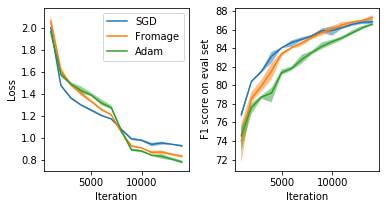

In [4]:
from tensorboard.backend.event_processing import event_accumulator # Install tensorboard to run this block!

steps = range(1000,15000,1000)

alg_list = ['SGD0.1', 'fromage0.001', 'adam0.0001',]
alg_list_pretty = ['SGD', 'Fromage', 'Adam']
seed_list = [100,200,300]

losses = {}
f1s = {}

for alg in alg_list:
    loss = np.zeros((14,3))
    f1 = np.zeros((14,3))
    
    for seed_idx, seed in enumerate(seed_list):
        ea = event_accumulator.EventAccumulator(f'logs/transformers/{alg}seed{seed}')
        ea.Reload()
        
        loss[:,seed_idx] = [item.value for item in ea.Scalars('loss')]
        f1[:,seed_idx] = [item.value for item in ea.Scalars('eval_f1')]
    losses[alg] = loss
    f1s[alg] = f1

fig,a =  plt.subplots(1,2,figsize=(6,3))
for alg in alg_list:
    mean = np.mean(losses[alg],axis=1)
    maxi = np.max(losses[alg],axis=1)
    mini = np.min(losses[alg],axis=1)
    a[0].plot(steps,mean)
    a[0].fill_between(steps, maxi, mini, alpha=0.5)
    a[0].set_ylabel(r'Loss')
    a[0].set_xlabel(r'Iteration')
for alg in alg_list:    
    mean = np.mean(f1s[alg],axis=1)
    maxi = np.max(f1s[alg],axis=1)
    mini = np.min(f1s[alg],axis=1)
    a[1].plot(steps,mean)
    a[1].fill_between(steps, maxi, mini, alpha=0.5)
    a[1].set_yticks([72,74,76,78,80,82,84,86,88])
    a[1].set_xlabel(r'Iteration')
    a[1].set_ylabel(r'F1 score on eval set')
a[0].legend(alg_list_pretty)

plt.subplots_adjust(wspace = 0.32,hspace=0.3)

plt.savefig(f"figures/transformers.pdf", bbox_inches = 'tight', pad_inches = 0)
plt.show()

## MNIST depth
This block generates Figure 4 in the paper.

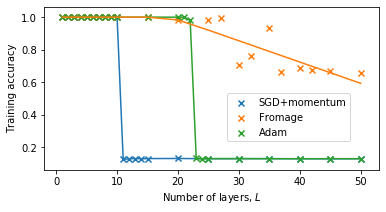

In [5]:
import os

directory = "logs/mnist-depth/100_epochs"

opt_list = ["SGD", "fromage", "adam"]
opt_list_pretty = ["SGD+momentum", "Fromage", "Adam"]
layer_list_orig = list(range(1,10)) + [10,15,20,25,30,35,40,45,50]

sgd_lrs = [1.0, 0.1, 0.01]
fromage_lrs = [0.1, 0.01, 0.001]
adam_lrs = [0.01, 0.001, 0.0001]

fig,a =  plt.subplots(1,1,figsize=(6,3))

for opt,alg,zorder in zip(opt_list,opt_list_pretty,[0,2,1]):
    layer_list = layer_list_orig + [] # add empty list to force a copy
    if opt == "SGD" or opt == "SGDwithoutmomentum": 
        lr_list = sgd_lrs
        layer_list += [11,12,13,14]
    if opt == "fromage": 
        lr_list = fromage_lrs
        layer_list += [27,32,37,42]
    if opt == "adam": 
        lr_list = adam_lrs
        layer_list += [21,22,23,24]
    layer_list.sort()
        
    last_epoch_means = []
            
    for layer_num in layer_list:
        train_accs = np.zeros((3,24000))
        for lr_idx, lr in enumerate(lr_list):
            filename = f'{opt}_layers_{layer_num}_initlr_{lr}_epochs100.npy'
            train_accs[lr_idx,:] = np.load(os.path.join(directory, filename))
        train_acc = np.max(train_accs,axis=0)
        last_epoch_mean = np.mean(train_acc[-240:])
        last_epoch_means.append(last_epoch_mean)
    a.scatter(layer_list,last_epoch_means,marker='x',label=alg)
    
    smoothed = np.asarray(last_epoch_means)
    if opt == "fromage":
        n = 10
        coefs = np.polyfit(layer_list[-n:], last_epoch_means[-n:],1)
        poly = np.poly1d(coefs)
        smoothed[-n:]= poly(layer_list[-n:])
    
    a.plot(layer_list,smoothed,zorder=zorder)
a.legend(bbox_to_anchor=(0.93,0.5))
a.set_xlabel(r'Number of layers, $L$')
a.set_ylabel("Training accuracy")
plt.savefig(f"figures/mnist-depth-100.pdf", bbox_inches = 'tight', pad_inches = 0)
plt.show()

## Cifar batch size
This block generates Figure 8 in the paper.

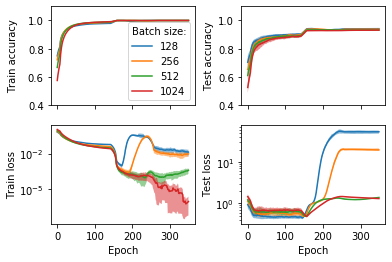

In [6]:
batch_size_list = [128,256,512,1024]
seed_list = [0,1,1337] # The l33t seed is a Twitter joke.
import pickle

def ax_plot(ax, series):
    for bsz in batch_size_list:
        y = np.zeros((3,350))
        for seed_idx, seed in enumerate(seed_list):
            fname = f"logs/cifar-batchsize/optim_fromage_lr_0.01_seed_{seed}_batchsize{bsz}.dict"
            y[seed_idx,:] = np.asarray(pickle.load( open( fname, "rb" ))[series])
        mean = np.mean(y,axis=0)
        maxi = np.max(y,axis=0)
        mini = np.min(y,axis=0)
        
        mean = moving_average(mean,w=15)
        maxi = moving_average(maxi,w=15)
        mini = moving_average(mini,w=15)
        
        ax.plot(mean)
        ax.fill_between(range(350), maxi, mini, alpha=0.5)
        

fig,a =  plt.subplots(2,2)
label_pad = 2.0

ax_plot(a[0][0], "train_acc")
a[0][0].legend(batch_size_list,ncol=1,loc="lower right",title="Batch size:")
a[0][0].set_ylim(0.4,1.1)
a[0][0].set_xticklabels([])
a[0][0].set_ylabel("Train accuracy")
a[0][0].yaxis.labelpad = label_pad + 8.2


ax_plot(a[0][1], "test_acc")
a[0][1].set_ylim(0.4,1.1)
a[0][1].set_xticklabels([])
a[0][1].set_ylabel("Test accuracy")
a[0][1].yaxis.labelpad = label_pad + 1.8

ax_plot(a[1][0], "train_loss")
a[1][0].set_yscale("log")
a[1][0].set_ylabel("Train loss")
a[1][0].set_xlabel("Epoch")
a[1][0].yaxis.labelpad = label_pad

ax_plot(a[1][1], "test_loss")
a[1][1].set_yscale("log")
a[1][1].set_ylabel("Test loss")
a[1][1].set_xlabel("Epoch")
a[1][1].yaxis.labelpad = label_pad

plt.subplots_adjust(wspace = 0.32)

plt.savefig(f"figures/cifar-batchsize.pdf", bbox_inches = 'tight', pad_inches = 0)
plt.show()

## Illustration of the main idea
This block generates Figure 1 in the paper.

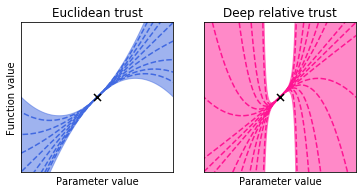

In [7]:
def quad_func(x,center):
    return (x-center)**2.0

def p_func(x,center,p):
    return np.abs(x-center)**p

def rel_func(x,center):
    return (1+((x-center)/center)**2.0)**20.0 -1

def trust_plot(ax,func,center,eps,color):

    x = np.arange(-50,50,0.1)
    ax.fill_between(x, x-center+eps*func(x,center), x-eps*func(x,center)-center, alpha=0.5,color=color,zorder=1)
    if color == "royalblue":
        ax.plot(x, x-center,'--',color=color,zorder=2)
        ax.plot(x, x-eps/2*quad_func(x,center)-center,'--',color=color,zorder=2)
        ax.plot(x, x+eps/2*quad_func(x,center)-center,'--',color=color,zorder=2)
        ax.plot(x, x-eps/4*quad_func(x,center)-center,'--',color=color,zorder=2)
        ax.plot(x, x+eps/4*quad_func(x,center)-center,'--',color=color,zorder=2)
        ax.plot(x, x-eps/1.5*quad_func(x,center)-center,'--',color=color,zorder=2)
        ax.plot(x, x-eps/1.25*quad_func(x,center)-center,'--',color=color,zorder=2)
        ax.plot(x, x+eps/1.25*quad_func(x,center)-center,'--',color=color,zorder=2)
    if color == "deeppink": # great coding
        ax.plot(x, x-center,'--',color=color,zorder=2)
        ax.plot(x, x+eps/2*rel_func(x,center)-center,'--',color=color,zorder=2)
        ax.plot(x, x-eps/2*rel_func(x,center)-center,'--',color=color,zorder=2)
        for p in [1.25,2,2.4,3,3.7]:
            ax.plot(x, x-eps*p_func(x,center,p)-center,'--',color=color,zorder=2)
            ax.plot(x, x+eps*p_func(x,center,p)-center,'--',color=color,zorder=2)
    ax.scatter([center],[0],marker="x",color='black',s=50,zorder=3)
    ax.set_ylim(-10,10)
    ax.set_xlim(-6,14)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("Parameter value")
    
fig,a =  plt.subplots(1,2,figsize=(6,2.75))

center = 4
eps = 0.1

trust_plot(a[0],quad_func,center,eps,"royalblue")
a[0].set_title("Euclidean trust")
a[0].set_ylabel("Function value")

trust_plot(a[1],rel_func,center,eps,"deeppink")
a[1].set_title("Deep relative trust")

plt.savefig(f"figures/illustration.png", dpi=600, bbox_inches = 'tight', pad_inches = 0)
plt.show()

## Surrogate trust
This block generates Figure 3 in the paper.
There is a typo in the paper indicating L=20 for this figure, when in fact we used L=10. This will be fixed in the next draft.

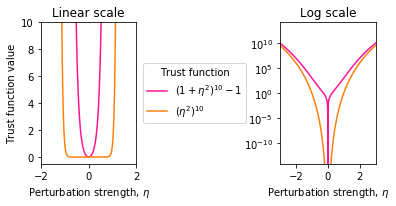

In [8]:
L = 10

def surr_func(x):
    return x**(2 * L)

def rel_func(x):
    return (1+x**2)**L -1

fig,a =  plt.subplots(1,2,figsize=(6,2.6))

for ax in [a[0],a[1]]:
    x = np.arange(-4,4,0.001)
    ax.plot(x,rel_func(x),color='deeppink')
    ax.plot(x,surr_func(x),color='C1')
    ax.set_xlabel(r"Perturbation strength, $\eta$")

a[1].set_yscale('log')

a[0].legend([r"$(1+\eta^2)^{10}-1$", r"$(\eta^2)^{10}$"],title=r"Trust function",loc="center right",bbox_to_anchor=(2.2, 0.5))

a[0].set_ylim((-0.5,10))
a[1].set_ylim((10**-14.1,10**14.1))

a[0].set_xlim((-2,2))
a[1].set_xlim((-3,3))

a[0].set_ylabel(r"Trust function value")

a[1].set_title("Log scale")
a[0].set_title("Linear scale")

plt.subplots_adjust(wspace = 1.5)
plt.savefig(f"figures/surrogate_trust.pdf", dpi=600, bbox_inches = 'tight', pad_inches = 0)
plt.show()

## Imagenet classification
This block generates Figure 6 in the paper.

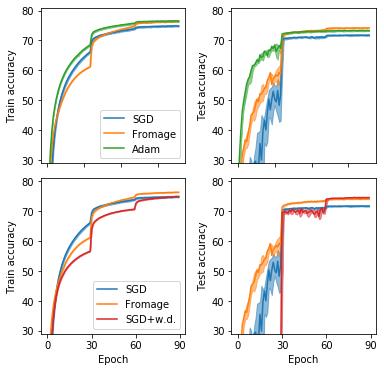

In [9]:
from tensorboard.backend.event_processing import event_accumulator # Install tensorboard to run this block!

steps = range(90)

alg_list = ['SGD_m-0.0', 'fromage', 'adam', 'SGD_m-0.0_wd-1e-4', 'SGD_m-0.9_wd-0.0', 'SGD_m-0.9_wd-1e-4']
alg_list_pretty = ['SGD', 'Fromage', 'Adam', 'SGD+w.d.', 'SGD+mom', 'SGD+wd+mom']
seed_list = [0,1,2]

train_accs = {}
test_accs = {}

for alg in alg_list:
    if alg == "SGD_m-0.0": lr = "1e1"
    if alg == "fromage": lr = "1e-2"
    if alg == "adam": lr = "1e-3"
    if alg == "SGD_m-0.0_wd-1e-4": lr = "1e0"
    if alg == "SGD_m-0.9_wd-0.0": lr = "1e-1"
    if alg == "SGD_m-0.9_wd-1e-4": lr = "1e-1"
        
    train_acc = np.zeros((90,3))
    test_acc = np.zeros((90,3))
    
    for seed_idx, seed in enumerate(seed_list):
        ea = event_accumulator.EventAccumulator(f'logs/imagenet/opt-{alg}_lr-{lr}_s-{seed}_wu-0')
        ea.Reload()
        
        train_acc[:,seed_idx] = [item.value for item in ea.Scalars('train/acc_top1')]
        test_acc[:,seed_idx] = [item.value for item in ea.Scalars('test/acc_top1')]
    
    train_accs[alg] = train_acc
    test_accs[alg] = test_acc
    
alg_lists = [alg_list[0:3], alg_list[0:2]+[alg_list[3]]]
alg_lists_pretty = [alg_list_pretty[0:3], alg_list_pretty[0:2]+[alg_list_pretty[3]]]
color_lists = [['C0','C1','C2'],['C0','C1','C3']]
tags = ['all','sgd']


fig,a =  plt.subplots(2,2,figsize=(6,6))

for row, alg_list, alg_list_pretty, tag, color_list in zip([0,1],alg_lists,alg_lists_pretty,tags,color_lists):

    for alg,color in zip(alg_list,color_list):
        mean = np.mean(train_accs[alg],axis=1)
        maxi = np.max(train_accs[alg],axis=1)
        mini = np.min(train_accs[alg],axis=1)
        a[row][0].plot(steps,mean,color=color)
        a[row][0].fill_between(steps, maxi, mini, alpha=0.5, color=color)
        a[row][0].set_ylabel(r'Train accuracy')
        a[row][0].set_ylim(29,81)
    for alg,color in zip(alg_list,color_list):
        mean = np.mean(test_accs[alg],axis=1)
        maxi = np.max(test_accs[alg],axis=1)
        mini = np.min(test_accs[alg],axis=1)

        maxi = moving_average(maxi,2)
        mini = moving_average(mini,2)

        a[row][1].plot(steps,mean,color=color)
        a[row][1].fill_between(steps, maxi, mini, alpha=0.5,color=color)
        a[row][1].set_ylabel(r'Test accuracy')
        a[row][1].set_ylim(29,81)
    a[row][0].legend(alg_list_pretty)

a[1][0].set_xticks([0,30,60,90])
a[1][1].set_xticks([0,30,60,90])
a[0][0].set_xticklabels([])
a[0][1].set_xticklabels([])
a[1][0].set_xlabel(r'Epoch')
a[1][1].set_xlabel(r'Epoch')

plt.subplots_adjust(wspace = 0.32,hspace=0.1)

plt.savefig(f"figures/imagenet.pdf", bbox_inches = 'tight', pad_inches = 0)
plt.show()

## CIFAR-10 GAN FID
This block generates Figure 5 in the paper.

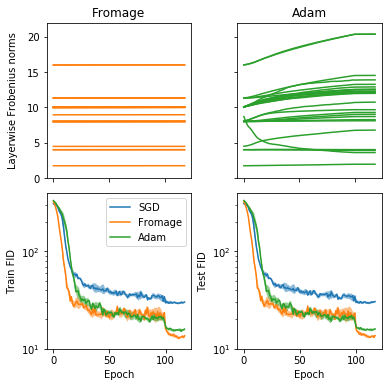

In [10]:
from tensorboard.backend.event_processing import event_accumulator

steps = range(118) # 8 runs ran for 119 epochs, the final run ran for 118... let's just truncate all of them

alg_list = ['sgd', 'fromage', 'adam']
alg_list_pretty = ['SGD', 'Fromage', 'Adam']
seed_list = [1,2,3]

train_fids = {}
test_fids = {}

for alg in alg_list:        
    train_fid = np.zeros((118,3))
    test_fid = np.zeros((118,3))
    
    for seed_idx, seed in enumerate(seed_list):
        ea = event_accumulator.EventAccumulator(f'logs/cifar-gan/{alg}.yaml_seed{seed}/tb')
        ea.Reload()
        
        train_fid[:,seed_idx] = [item.value for item in ea.Scalars('fid/train')][:118]
        test_fid[:,seed_idx] = [item.value for item in ea.Scalars('fid/test')][:118]
        
    train_fids[alg] = train_fid
    test_fids[alg] = test_fid
    
fig,a =  plt.subplots(2,2,figsize=(6,6))
for alg in alg_list:
    mean = np.mean(train_fids[alg],axis=1)
    maxi = np.max(train_fids[alg],axis=1)
    mini = np.min(train_fids[alg],axis=1)
    
    maxi = moving_average(maxi,3)
    mini = moving_average(mini,3)
    
    ax = a[1][0]
    
    ax.plot(steps,mean)
    ax.fill_between(steps, maxi, mini, alpha=0.5)
    ax.set_ylabel(r'Train FID')
    ax.set_xlabel(r'Epoch')
    ax.set_yscale('log')
    ax.set_yticks([10,100])
for alg in alg_list:
    mean = np.mean(test_fids[alg],axis=1)
    maxi = np.max(test_fids[alg],axis=1)
    mini = np.min(test_fids[alg],axis=1)

    maxi = moving_average(maxi,3)
    mini = moving_average(mini,3)

    ax = a[1][1]
    
    ax.plot(steps,mean)
    ax.fill_between(steps, maxi, mini, alpha=0.5)
    ax.set_xlabel(r'Epoch')
    ax.set_ylabel(r'Test FID')
    ax.set_yscale('log')
    ax.set_yticks([10,100])
a[1][0].legend(alg_list_pretty)

alg_list = ['fromage','adam']
alg_list_pretty = ['Fromage','Adam']
color_list = ['C1','C2']
seed = 1

for ax,alg,alg_pretty,color in zip([0,1],alg_list,alg_list_pretty,color_list):
    ea = event_accumulator.EventAccumulator(f'logs/cifar-gan/{alg}.yaml_seed{seed}/tb')
    ea.Reload()
        
    for tag in ea.Tags()['scalars']:
        if "netG_frob" in tag:
            series = [item.value for item in ea.Scalars(tag)]
            a[0][ax].plot(series,color=color)
    a[0][ax].set_ylim((0,22))
    a[0][ax].set_title(alg_pretty)
    a[0][ax].set_xticklabels([])
a[0][0].set_ylabel("Layerwise Frobenius norms")
a[0][0].yaxis.labelpad = 9.2
a[0][1].set_yticklabels([])

plt.subplots_adjust(wspace = 0.32,hspace=0.1)

plt.savefig(f"figures/cifar-gan.pdf", bbox_inches = 'tight', pad_inches = 0)
plt.show()

## Validating the effect of stability correction
Here we plot the norms for all spectrally normalised layers in a GAN training run. The LARS version takes the Fromage code and comments out the stability correction.

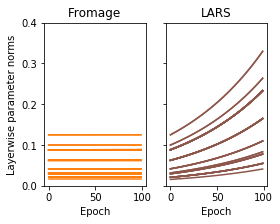

In [46]:
from tensorboard.backend.event_processing import event_accumulator

alg_list = ['fromage', 'lars']
alg_list_pretty = ['Fromage', 'LARS']
color_list = ['C1','C5']

fig,a =  plt.subplots(1,2,figsize=(4,3))

for ax, alg, alg_pretty, color in zip([0,1],alg_list,alg_list_pretty,color_list):
    ea = event_accumulator.EventAccumulator(f'logs/cifar-gan/lars/{alg}-0.01-seed0')
    ea.Reload()
        
    for tag in ea.Tags()['scalars']:
        if "weight_orig" in tag:
            series = [item.value for item in ea.Scalars(tag)][0:100] # lr decay happens at epoch 100
            a[ax].plot(series,color=color)
    a[ax].set_ylim((0,0.4))
    a[ax].set_title(alg_pretty)
    a[ax].set_xlabel("Epoch")
    a[ax].set_xticks([0,50,100])
    a[ax].set_yticks([0.0,0.1,0.2,0.3,0.4])
a[0].set_ylabel("Layerwise parameter norms")
a[1].set_yticklabels([])
plt.savefig(f"figures/lars-norms.pdf", bbox_inches = 'tight', pad_inches = 0)
plt.show()